<a href="https://colab.research.google.com/github/Sandeephm/GoogleColab-codes/blob/master/Sentiment_Analysis_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compare the performance of CNN, LSTM, GRU and stacked LSTM on glue sst2 dataset

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete24XLII/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete24XLII/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incomplete24XLII/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [4]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [5]:
# Print some of the entries
for example in dataset_train.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [6]:
# Print some of the entries
for example in dataset_train.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [7]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


In [0]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 32
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

In [0]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            128000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,033
Trainable params: 128,033
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6826 - accuracy: 0.5593 - val_loss: 0.6845 - val_accuracy: 0.5321
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6647 - accuracy: 0.5894 - val_loss: 0.6559 - val_accuracy: 0.6330
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6298 - accuracy: 0.6636 - val_loss: 0.6154 - val_accuracy: 0.6950
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5841 - accuracy: 0.7166 - val_loss: 0.5715 - val_accuracy: 0.7271
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5393 - accuracy: 0.7534 - val_loss: 0.5386 - val_accuracy: 0.7294
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4985 - accuracy: 0.7880 - val_loss: 0.5143 - val_accuracy: 0.7580
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4632 - accuracy: 0.8077 - val_loss: 0.4969 - val_accuracy: 0.7580
Epoch 

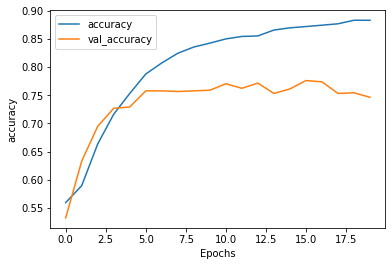

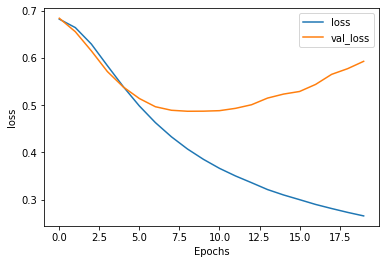

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Functions for Creating Model, Training, Predicting and Visualizing Error and Accuracy**

In [0]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [14]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)

I loved this movie
[0.45959008]


that was the worst movie I've ever seen
[0.10372853]


too much violence even for a Bond film
[0.01311295]


a captivating recounting of a cherished myth
[0.73588276]




In [0]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

#**Using a CNN**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            128000    
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            2576      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 130,593
Trainable params: 130,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 1s 4ms/step - loss: 0.6867 - accuracy: 0.5556 - val_loss: 0.6917 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 1s 5ms/step - loss: 0.6784 - accuracy: 0.5590 - va

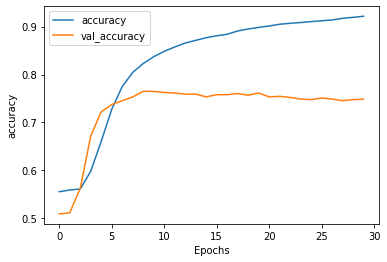

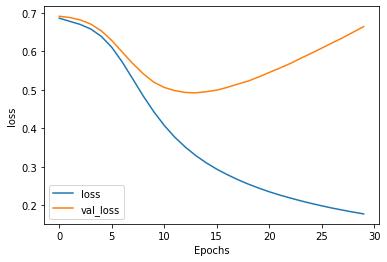

I loved this movie
[0.91733193]


that was the worst movie I've ever seen
[0.01374891]


too much violence even for a Bond film
[0.00036415]


a captivating recounting of a cherished myth
[0.8357677]




In [16]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

#**Using A GRU**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12672     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 140,737
Trainable params: 140,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 3s 11ms/step - loss: 0.6914 - accuracy: 0.5321 - val_loss: 0.6932 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6864 - accuracy: 0.5590 - val_loss: 0.6943 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 3s 8ms/step - loss: 0.6841 - accuracy: 

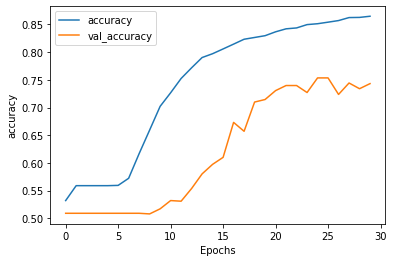

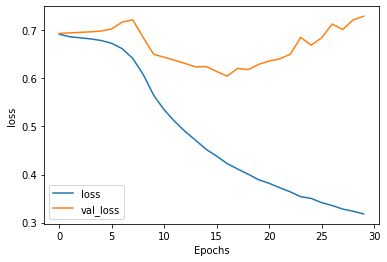

I loved this movie
[0.38235617]


that was the worst movie I've ever seen
[0.09631243]


too much violence even for a Bond film
[0.06155111]


a captivating recounting of a cherished myth
[0.4645899]




In [17]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

#**Using a LSTM**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            128000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 144,705
Trainable params: 144,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 3s 10ms/step - loss: 0.6902 - accuracy: 0.5480 - val_loss: 0.6937 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6856 - accuracy: 0.5590 - val_loss: 0.6947 - val_accuracy: 0.5092
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6835 - accuracy: 

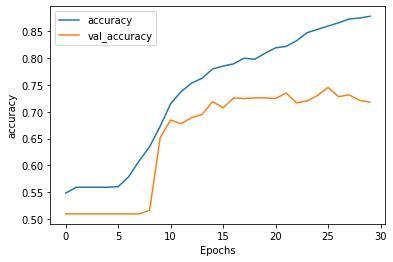

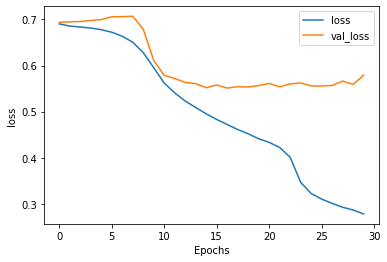

I loved this movie
[0.18689863]


that was the worst movie I've ever seen
[0.0751837]


too much violence even for a Bond film
[0.06577227]


a captivating recounting of a cherished myth
[0.61355996]




In [18]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

#**Using Multiple Bi-Directional LSTM**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 32)            128000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 64)            16640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 169,537
Trainable params: 169,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 5s 16ms/step - loss: 0.6569 - accuracy: 0.5980 - val_loss: 0.7177 - val_accuracy: 0.4908
Epoch 2/30
313/313 [==============================] - 4s 13ms/step - loss: 0.4333 - accuracy: 0.7923 - 

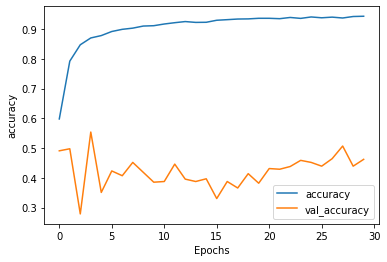

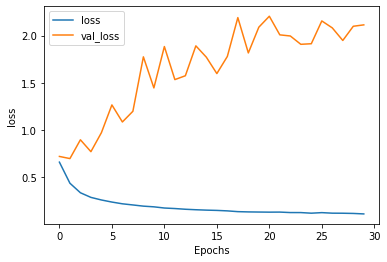

I loved this movie
[0.9962011]


that was the worst movie I've ever seen
[0.9191323]


too much violence even for a Bond film
[0.00472141]


a captivating recounting of a cherished myth
[0.99790573]




In [19]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

#**Comparision Of Predictionss of Different Models**

In [0]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

review11 = "Batman and Dark Knight is an all time classic"

review12 = "Shitty movie"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10,review11,review12]


In [21]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.45959008]


that was the worst movie I've ever seen
[0.10372853]


too much violence even for a Bond film
[0.01311295]


a captivating recounting of a cherished myth
[0.73588276]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.39331093]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.659008]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.39181787]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5871712]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00408378]


I wish I cou

In [22]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
I loved this movie
[0.91733193]


that was the worst movie I've ever seen
[0.01374892]


too much violence even for a Bond film
[0.00036415]


a captivating recounting of a cherished myth
[0.8357677]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.65235764]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.98372895]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.609296]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.6401351]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.01921526]


I wish I could watch 

In [23]:
print("===========================\n","With GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With GRU
I loved this movie
[0.38235617]


that was the worst movie I've ever seen
[0.0963124]


too much violence even for a Bond film
[0.06155111]


a captivating recounting of a cherished myth
[0.4645899]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.07906915]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.16194105]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.09074375]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.206255]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.04928969]


I wish I could watch 

In [24]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.18689868]


that was the worst movie I've ever seen
[0.0751837]


too much violence even for a Bond film
[0.06577227]


a captivating recounting of a cherished myth
[0.61355996]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.24522053]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.10973506]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.06347741]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.70344484]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.03602

In [25]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.9962011]


that was the worst movie I've ever seen
[0.9191324]


too much violence even for a Bond film
[0.00472141]


a captivating recounting of a cherished myth
[0.99790573]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.99968636]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9998683]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.04286955]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99984694]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0073638